## Climate Analysis

In [1]:
import matplotlib
matplotlib.use('nbagg')
#%matplotlib notebook
from matplotlib import style
#style.use('fivethirtyeight')
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import csv
import os
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd

In [4]:
from datetime import datetime as dt, timedelta

In [5]:
#SQL Alchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

# Reflect Tables into SQLAlchemy ORM

### Hawaii SQLLite DB 

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# Get the tables in the Hawaii Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Get column and types for Measurement Table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Get column and types Station Table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [14]:
# Retrieve Latest Date
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]
format_latest_date = dt.strptime(latest_date,"%Y-%m-%d")

# Design a query to retrieve the last 12 months of precipitation data.
sel = [Measurements.date, func.avg(Measurements.prcp)]
last_year_date = format_latest_date - timedelta(days=365)  
prcp_data = session.query(*sel).\
    filter((Measurements.date >= last_year_date)).\
    group_by(Measurements.date).\
    order_by(Measurements.date).all()

In [15]:
len(prcp_data)

365

In [16]:
# Create the Dataframe for storing the SQL query results for last 12 months of preceipitation data
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True) 
prcp_df.head()

Precipitation
Date                     
2016-08-24       1.332857
2016-08-25       0.077143
2016-08-26       0.016667
2016-08-27       0.053333
2016-08-28       0.516667

#### Precipitation Summary Statistics (from Dataframe)

In [17]:
prcp_df.describe()

Precipitation
count     365.000000
mean        0.156103
std         0.275657
min         0.000000
25%         0.008571
50%         0.065000
75%         0.175714
max         2.040000

### Precipitation Plot

<IPython.core.display.Javascript object>


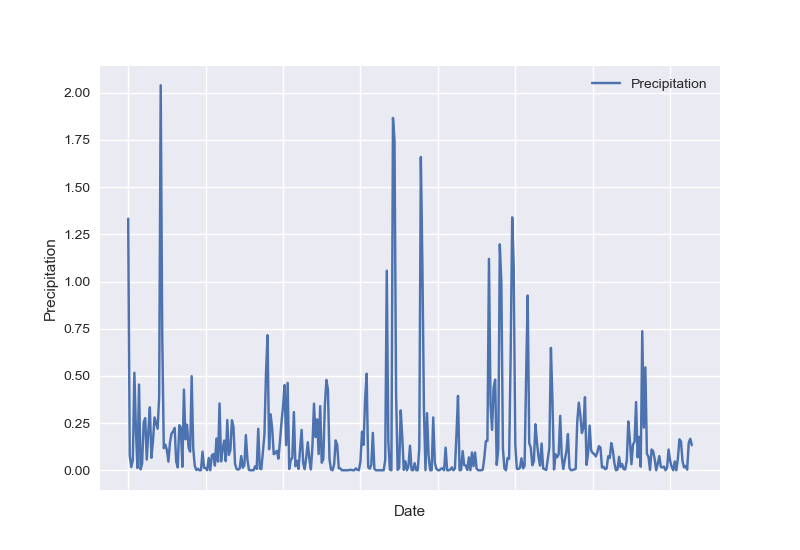

In [18]:
# Create the plot# Create 
prcp_df.plot()
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.savefig("precipitation_analysis.png")
plt.show()

## Station Analysis

In [19]:
# Design a query to calculate the total number of stations.
station_count = session.query(Stations.id).count()
print (f"Station Count = {station_count}")

Station Count = 9


In [20]:
# Query for finding the most active stations
# List the stations and observation counts in descending order
sel = [Measurements.station, func.count(Measurements.tobs)]
active_stations_data = session.query(*sel). \
            group_by(Measurements.station). \
            order_by(desc(func.count(Measurements.tobs))). \
            all()
active_stations_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
print(f"Station with highest # of Observations: {active_stations_data[0]}")

Station with highest # of Observations: ('USC00519281', 2772)


In [22]:
highest_station = active_stations_data[0][0] #Storing the highest station as a variable
highest_station

'USC00519281'

In [23]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

sel = [Measurements.tobs]
temperature_data = session.query(*sel).\
    filter(Measurements.date >= last_year_date).\
    filter(Measurements.station == highest_station).all()

In [24]:
tobs_data = []
for row in temperature_data:
    tobs_data.append(row[0])

<IPython.core.display.Javascript object>


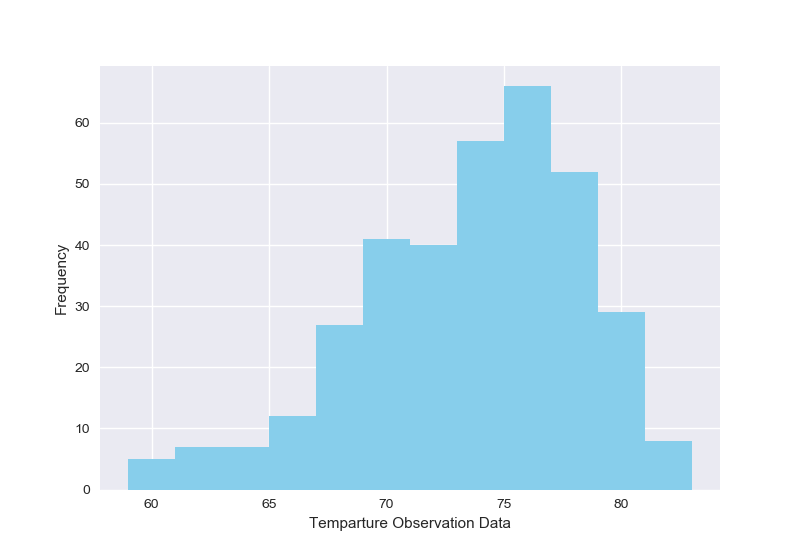

In [25]:
plt.hist(tobs_data, bins=12, label='tobs', color = 'skyblue')
plt.xlabel("Temparture Observation Data")
plt.ylabel("Frequency")
plt.savefig("station_analysis.png")
plt.show()

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

print(f"lowest_temp = {min(tobs_data)} \
        highest_temp = {max(tobs_data)}\
        avg_temp_of_most_active_station = {np.mean(tobs_data)}")

lowest_temp = 59.0         highest_temp = 83.0        avg_temp_of_most_active_station = 73.0968660968661


## Code for Temperature Analysis

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    Start_Date = dt.strptime(start_date, "%Y-%m-%d")
    Start_Date = Start_Date.replace(Start_Date.year - 1)
    End_Date = dt.strptime(end_date, "%Y-%m-%d")
    End_Date = End_Date.replace(End_Date.year - 1)
    
    #Collect all the dates between start date and end date
    delta = End_Date - Start_Date
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(Start_Date + timedelta(days=i))
       
    #Converting to stings
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
       
   #Calculate Average Tempareure , Min and Maximum temperatures within the date range    
    temp_avg = session.query(func.avg(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
       
    return temp_avg, temp_min, temp_max
print(calc_temps('2012-02-28', '2012-03-05'))

(69.75510204081633, 61.0, 75.0)


In [27]:
start_date = input("Please enter your trip's start date in YYYY-MM-DD: ")
end_date = input ("Please enter your trip's end date in YYYY-MM-DD: ")

Please enter your trip's start date in YYYY-MM-DD: 2018-04-01
Please enter your trip's end date in YYYY-MM-DD: 2018-04-10


In [28]:
trip_analysis = calc_temps(start_date, end_date)

tavg = trip_analysis[0]
tmin = trip_analysis[1]
tmax = trip_analysis[2]

<IPython.core.display.Javascript object>


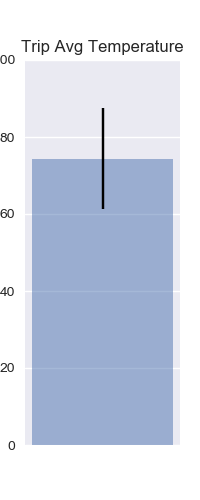

In [29]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.

# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

# Plot Bar chart 
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temperature")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
#plt.savefig("temperature_analysis.png")
plt.show()